In [ ]:
%cd drive/'My Drive'/ex1_predict

[Errno 2] No such file or directory: 'drive/My Drive/ex1_predict'
/content/drive/My Drive/ex1_predict


In [ ]:
!pip install dtaidistance

In [ ]:
from dtaidistance import dtw
from fastdtw import fastdtw
import array
from scipy.spatial.distance import euclidean
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import json
import enum
import sklearn.preprocessing
import argparse
import tensorflow.compat.v1 as tf
import pickle

In [ ]:
# list_GMfile = np.array(['H-E12140'])
list_GMfile = ['kobe', 'elsalvado', 'indiana', 'fairbank', 'nenana', 'tonalapa', 'taiwan_1', 'taiwan_2', 'kardista', 'santiago', 'lima', 'rarakau', 'simeon']
list_GMfact = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

In [ ]:
GMfile = []
for i in range(len(list_GMfile)):
    GMfile += [list_GMfile[i]] * len(list_GMfact)

GMfact = list_GMfact * len(list_GMfile)


In [ ]:
def _batch_single_entity(input_data, params):
  data_steps = len(input_data)
  lags = params['total_time_steps']
  x = input_data.values
  if data_steps >= lags:
    return np.stack([x[i:data_steps - (lags - 1) + i, :] for i in range(lags)], axis=1)


In [ ]:
def df_to_data(df, col_mappings, params):
    data_map = {}
    for k in col_mappings:
      cols = col_mappings[k]
      arr = _batch_single_entity(df[cols].copy(), params)

      if k not in data_map:
        data_map[k] = [arr]
      else:
        data_map[k].append(arr)

    # Combine all data
    for k in data_map:
      data_map[k] = np.concatenate(data_map[k], axis=0)

    num_encoder_steps = params['num_encoder_steps']
    data_map['outputs'] = data_map['outputs'][:, num_encoder_steps:, :]
    
    return data_map


In [ ]:
exclude = [94, 95, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]

col_mappings = {
  'identifier': ['id'],
  'outputs': [1],
  'inputs': [1, 15],
  # 'inputs': [1, 2, 12, 15],
  }


In [ ]:
def get_simulate(id, params):
  df = pd.read_csv(f'{GMfile[id]}.g3', sep=' ', header=None)
  Ncol = len(list(df))
  g = np.zeros(len(df)*Ncol)
  for i in range(Ncol):
      g[i::Ncol]=df[i]

  g = g[~np.isnan(g)]
  g = g[::2]*GMfact[id]
  df = pd.read_csv(f'disp_{id}.out', sep=' ', header=None)
  df = df[:3000]
  df[15] = g
  df['id'] = 'acc'

  return df

In [ ]:
# Combine all df to calculate scaler
df_all = pd.DataFrame()
for i in range(100):
    if i not in exclude:
        df = pd.read_csv(f'{GMfile[i]}.g3', sep=' ', header=None)
        Ncol = len(list(df))
        g = np.zeros(len(df)*Ncol)
        for i in range(Ncol):
            g[i::Ncol]=df[i]

        g = g[~np.isnan(g)]
        g = g[::2]*GMfact[i]
        df = pd.read_csv(f'disp_{i}.out', sep=' ', header=None)
        df = df[:3000]
        df[15] = g
        df['id'] = 'acc'       
        df_all=pd.concat([df_all, df])

real_scalers = sklearn.preprocessing.StandardScaler().fit(df_all[col_mappings['inputs']].values)
output_scalers = sklearn.preprocessing.StandardScaler().fit(df_all[col_mappings['outputs']].values)

In [ ]:
# scaled train data, e.g.: 'inputs': (242649, 550, 4)
params = {}
params['total_time_steps']  = 550
params['num_encoder_steps'] = 500

i = 0
df = get_simulate(i, params)
df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
data_all = df_to_data(df, col_mappings, params)


In [ ]:
for i in range(100):
    if i not in exclude:
        if i%20 == 0:
          print(i)        

        df = get_simulate(i, params)
        df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
        data_map = df_to_data(df, col_mappings, params)
        data_all['inputs'] = np.concatenate((data_all['inputs'], data_map['inputs']), axis = 0)
        data_all['outputs'] = np.concatenate((data_all['outputs'], data_map['outputs']), axis = 0)

0
20
40
60
80


In [ ]:
Nsplit = 5000
data, labels = data_all['inputs'][:-Nsplit], data_all['outputs'][:-Nsplit] 
val_data, val_labels = data_all['inputs'][-Nsplit:], data_all['outputs'][-Nsplit:] 

In [ ]:
N_input_size = len(col_mappings['inputs'])

params = {
 'dropout_rate': 0.1,
 'early_stopping_patience': 5,
 'hidden_layer_size': 160,
 'input_obs_loc': [0],
 'input_size': N_input_size,
#  'known_regular_inputs': list(range(1,N_input_size)),
 'known_regular_inputs': [N_input_size-1],
 'learning_rate': 0.001,
 'max_gradient_norm': 0.01,
 'minibatch_size': 256,
 'model_folder': 'electricity/saved_models/electricity/fixed',
 'multiprocessing_workers': 5,
 'num_encoder_steps': 500,
 'num_epochs': 100,
 'num_heads': 4,
 'output_size': 1,
 'stack_size': 1,
  'total_time_steps': 550}

In [ ]:
name, output_folder, use_tensorflow_with_gpu = 'ex1', 'ex1', 'yes'
default_keras_session = tf.keras.backend.get_session()
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
tf_config = tf.compat.v1.ConfigProto(log_device_placement=False)
tf_config.gpu_options.allow_growth = True
tf.global_variables_initializer()


In [ ]:
all_callbacks = [
    tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=params['early_stopping_patience'], min_delta=1e-4),
    tf.keras.callbacks.ModelCheckpoint( filepath=os.path.join(params['model_folder'], 'bbb.check'), monitor='val_loss',
        save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.ProgbarLogger(count_mode="samples", stateful_metrics=None)    ]


In [ ]:
def get_active_locations(x):
  """Formats sample weights for Keras training."""
  return (np.sum(x, axis=-1) > 0.0) * 1.0


In [ ]:
all_inputs = tf.keras.layers.Input(shape=(params['total_time_steps'], params['input_size'],))


In [ ]:
def convert_real_to_embedding(x):
  return tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(params['hidden_layer_size']))(x)



In [ ]:
def gated_residual_network(x, hidden_layer_size, output_size=None, dropout_rate=None,
                           use_time_distributed=True, additional_context=None, return_gate=False):

  # Setup skip connection
  if output_size is None:
    output_size = hidden_layer_size
    skip = x
  else:
    linear = tf.keras.layers.Dense(output_size)
    if use_time_distributed:
      linear = tf.keras.layers.TimeDistributed(linear)
    skip = linear(x)

  # Apply feedforward network
  hidden = linear_layer( hidden_layer_size, activation=None, use_time_distributed=use_time_distributed)(x) 
  hidden = tf.keras.layers.Activation('elu')(hidden)
  hidden = linear_layer(hidden_layer_size, activation=None, use_time_distributed=use_time_distributed)(hidden)
  gating_layer, gate = apply_gating_layer( hidden,output_size,dropout_rate=dropout_rate, 
                                          use_time_distributed=use_time_distributed, activation=None)

  if return_gate:
    return add_and_norm([skip, gating_layer]), gate
  else:
    return add_and_norm([skip, gating_layer])


In [ ]:
def linear_layer(size, activation=None, use_time_distributed=False, use_bias=True):

  linear = tf.keras.layers.Dense(size, activation=activation, use_bias=use_bias)
  if use_time_distributed:
    linear = tf.keras.layers.TimeDistributed(linear)
  return linear

In [ ]:
def apply_gating_layer(x, hidden_layer_size, dropout_rate=None, use_time_distributed=True, activation=None):

  if dropout_rate is not None:
    x = tf.keras.layers.Dropout(dropout_rate)(x)

  if use_time_distributed:
    activation_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation=activation))(x)
    
    gated_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'))(x)
  
  else:
    activation_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation=activation)(x)

    gated_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation='sigmoid')(x)

  return tf.keras.layers.Multiply()([activation_layer,gated_layer]), gated_layer


In [ ]:
def add_and_norm(x_list):
  tmp = tf.keras.layers.Add()(x_list)
  tmp = tf.keras.layers.LayerNormalization()(tmp)
  return tmp


In [ ]:
def get_decoder_mask(self_attn_inputs):
  len_s = tf.shape(self_attn_inputs)[1]
  bs = tf.shape(self_attn_inputs)[:1]  
  mask = tf.keras.backend.cumsum(tf.eye(len_s, batch_shape=bs), 1)
  return mask


In [ ]:
num_encoder_steps = int(params['num_encoder_steps'])
output_size = int(params['output_size'])
quantiles = [0.1, 0.5, 0.9]


In [ ]:
def tensorflow_quantile_loss(y, y_pred, quantile):
  prediction_underflow = y - y_pred
  q_loss = quantile * tf.maximum(prediction_underflow, 0.) + (
      1. - quantile) * tf.maximum(-prediction_underflow, 0.)

  return tf.reduce_sum(q_loss, axis=-1)

In [ ]:
class QuantileLossCalculator(object):
  def __init__(self, quantiles):
    self.quantiles = quantiles

  def quantile_loss(self, a, b):
    quantiles_used = set(self.quantiles)

    loss = 0.
    for i, quantile in enumerate(valid_quantiles):
      if quantile in quantiles_used:
        loss += tensorflow_quantile_loss(
            a[Ellipsis, output_size * i:output_size * (i + 1)],
            b[Ellipsis, output_size * i:output_size * (i + 1)], quantile)
    return loss

In [ ]:
max_gradient_norm = float(params['max_gradient_norm'])
learning_rate = float(params['learning_rate'])
adam = tf.keras.optimizers.Adam(lr=learning_rate, clipnorm=max_gradient_norm)
valid_quantiles = quantiles
quantile_loss = QuantileLossCalculator(valid_quantiles).quantile_loss
minibatch_size = int(params['minibatch_size'])
n_multiprocessing_workers = int(params['multiprocessing_workers'])

In [ ]:
def temp(all_inputs, params):
  time_steps = int(params['total_time_steps'])
  combined_input_size = int(params['input_size'])
  encoder_steps = int(params['num_encoder_steps'])
  hidden_layer_size = int(params['hidden_layer_size'])
  _known_regular_input_idx = json.loads(str(params['known_regular_inputs']))
  dropout_rate = float(params['dropout_rate'])
  input_size = int(params['input_size'])
  num_regular_variables = input_size 

  regular_inputs = all_inputs[:, :, :num_regular_variables]
  # Targets
  _input_obs_loc = json.loads(str(params['input_obs_loc']))
  obs_inputs = tf.keras.backend.stack([
  convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1]) for i in _input_obs_loc], axis=-1)
  unknown_inputs = []
  for i in range(regular_inputs.shape[-1]):
    if i not in _known_regular_input_idx and i not in _input_obs_loc:
      e = convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
      unknown_inputs.append(e)

  known_regular_inputs = [
      convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
      for i in _known_regular_input_idx]

  known_combined_layer = tf.keras.backend.stack(known_regular_inputs, axis=-1)
  historical_inputs = tf.keras.backend.concatenate([known_combined_layer[:, :encoder_steps, :], obs_inputs[:, :encoder_steps, :]],axis=-1)
  future_inputs = known_combined_layer[:, encoder_steps:, :]
  _, time_steps, embedding_dim, num_inputs = historical_inputs.get_shape().as_list()
  flatten = tf.keras.backend.reshape(historical_inputs, [-1, time_steps, embedding_dim * num_inputs])
  mlp_outputs, _ = gated_residual_network( flatten, hidden_layer_size, output_size=num_inputs, dropout_rate= dropout_rate,
            use_time_distributed=True, return_gate=True)

  sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
  sparse_weights = tf.expand_dims(sparse_weights, axis=2)

  trans_emb_list = []
  for i in range(num_inputs):
    grn_output = gated_residual_network( historical_inputs[Ellipsis, i], hidden_layer_size, dropout_rate=dropout_rate,
        use_time_distributed=True)
    trans_emb_list.append(grn_output)

  transformed_embedding = tf.keras.backend.stack(trans_emb_list, axis=-1)
  combined = tf.keras.layers.Multiply()([sparse_weights, transformed_embedding])
  temporal_ctx = tf.keras.backend.sum(combined, axis=-1)
  historical_features, historical_flags = temporal_ctx, sparse_weights

  _, time_steps, embedding_dim, num_inputs = future_inputs.get_shape().as_list()
  flatten = tf.keras.backend.reshape(future_inputs, [-1, time_steps, embedding_dim * num_inputs])
  
  mlp_outputs, _ = gated_residual_network(flatten,hidden_layer_size, output_size=num_inputs,dropout_rate=dropout_rate,
            use_time_distributed=True, return_gate=True)

  sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
  sparse_weights = tf.expand_dims(sparse_weights, axis=2)

  trans_emb_list = []
  for i in range(num_inputs):
    grn_output = gated_residual_network( future_inputs[Ellipsis, i], hidden_layer_size, dropout_rate=dropout_rate,
        use_time_distributed=True)
    trans_emb_list.append(grn_output)

  transformed_embedding = tf.keras.backend.stack(trans_emb_list, axis=-1)
  combined = tf.keras.layers.Multiply()([sparse_weights, transformed_embedding])
  temporal_ctx = tf.keras.backend.sum(combined, axis=-1)
  future_features, future_flags = temporal_ctx, sparse_weights
  history_lstm, state_h, state_c = tf.compat.v1.keras.layers.CuDNNLSTM(hidden_layer_size, return_sequences=True, return_state=True, stateful=False)(historical_features)
  future_lstm = tf.compat.v1.keras.layers.CuDNNLSTM(hidden_layer_size, return_sequences=True, return_state=False, stateful=False)(future_features, initial_state=[state_h, state_c])
  lstm_layer = tf.keras.backend.concatenate([history_lstm, future_lstm], axis=1)
  lstm_layer, _ = apply_gating_layer(lstm_layer, hidden_layer_size, dropout_rate, activation=None)
  input_embeddings = tf.keras.backend.concatenate([historical_features, future_features], axis=1)
  temporal_feature_layer = add_and_norm([lstm_layer, input_embeddings])
  enriched, _ = gated_residual_network(temporal_feature_layer, hidden_layer_size, dropout_rate=dropout_rate,
          use_time_distributed=True, return_gate=True)

  # Attention
  num_heads = int(params['num_heads'])
  mask = get_decoder_mask(enriched)
  heads = []
  d_k = d_v = hidden_layer_size // num_heads

  for i in range(num_heads):
    q = tf.keras.layers.Dense(d_k, use_bias=False)(enriched)
    k = tf.keras.layers.Dense(d_k, use_bias=False)(enriched)
    v = tf.keras.layers.Dense(d_k, use_bias=False)(enriched) 
    temper = tf.sqrt(tf.cast(tf.shape(k)[-1], dtype='float32'))
    attn = tf.keras.layers.Lambda(lambda x :  tf.keras.backend.batch_dot(x[0], x[1], axes=[2, 2]) )([q, k])  
    attn = attn / temper

    if mask is not None:
      mmask = tf.keras.layers.Lambda(lambda x: (-1e+9) * (1. - tf.keras.backend.cast(x, 'float32')))(mask)  # setting to infinity
      attn = tf.keras.layers.Add()([attn, mmask])

    attn = tf.keras.layers.Activation('softmax')(attn)
    attn = tf.keras.layers.Dropout(0.0)(attn)
    head = tf.keras.layers.Lambda(lambda x: tf.keras.backend.batch_dot(x[0], x[1]))([attn, v]) 
    head_dropout = tf.keras.layers.Dropout(dropout_rate)(head)
    heads.append(head_dropout)
    
  head = tf.keras.backend.stack(heads) if num_heads > 1 else heads[0]
  x = tf.keras.backend.mean(head, axis=0) if num_heads > 1 else head
  x = tf.keras.layers.Dense(hidden_layer_size, use_bias=False)(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)  # output dropout
  x, _ = apply_gating_layer(x,hidden_layer_size,dropout_rate=dropout_rate,activation=None)
  x = add_and_norm([x, enriched])
  decoder = gated_residual_network(x, hidden_layer_size, dropout_rate=dropout_rate, use_time_distributed=True)
  decoder, _ = apply_gating_layer(decoder, hidden_layer_size, activation=None)
  transformer_layer = add_and_norm([decoder, temporal_feature_layer])
  outputs = transformer_layer[Ellipsis, num_encoder_steps:, :]
  outputs = tf.keras.layers.TimeDistributed( tf.keras.layers.Dense(output_size * len(quantiles))) (outputs)

  return outputs


In [ ]:
# Nsplit = 1000
data, labels = data_all['inputs'][::10], data_all['outputs'][::10] 
val_data, val_labels = data_all['inputs'][5::100], data_all['outputs'][5::100] 
np.shape(data)

(24265, 550, 2)

In [ ]:
num_epochs = 10
all_inputs = tf.keras.layers.Input(shape=(params['total_time_steps'], params['input_size'],))
outputs = temp(all_inputs, params)
model = tf.keras.Model(inputs=all_inputs, outputs=outputs)
model.compile(loss=quantile_loss, optimizer=adam, sample_weight_mode='temporal')


In [ ]:
all_callbacks = [
    # tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=params['early_stopping_patience'], min_delta=1e-4),
    tf.keras.callbacks.ModelCheckpoint( filepath=os.path.join(params['model_folder'], 'ttt.check'), monitor='val_loss',
        save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.CSVLogger('log.csv', separator=",", append=False),
    # tf.keras.callbacks.ProgbarLogger(count_mode="samples", stateful_metrics=None)  
      ]

## TRAIN

In [ ]:
# hist= model.fit(
#         x=data,
#         y=np.concatenate([labels, labels, labels], axis=-1),
#         epochs=10,
#         batch_size=128,
#         validation_data=(val_data, np.concatenate([val_labels, val_labels, val_labels], axis=-1)),
#         callbacks=all_callbacks,
#         shuffle=True,
#         verbose = 1,
#         use_multiprocessing=True,
#         workers=n_multiprocessing_workers)

## Run statistic

In [ ]:
model.load_weights(filepath=os.path.join(params['model_folder'], 'eee.check')) 

In [ ]:
id = 130
print(GMfact[id], GMfile[id])
df = get_simulate(id, params)
df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
data_test = df_to_data(df, col_mappings, params)

x_actual  =  data_test['inputs'][:2500:50]
y_actual=  data_test['outputs'][:2500:50]


0.7 kardista


In [ ]:
motion = np.empty(3000)
y_one_all = np.empty(3000)
y_rep_all = np.empty(3000)
y_true  = np.empty(3000)

motion[0:500]  =   x_actual[0,0:500,1]
motion[500:] = x_actual[:,-50:,1].reshape(-1)

y_one_all[0:500] = x_actual[0,0:500,0]
y_rep_all[0:500] = x_actual[0,0:500,0]
y_true[0:500] = x_actual[0,0:500,0]

y_one_all[500:] = x_actual[:,-50:,0].reshape(-1)
y_rep_all[500:] = x_actual[:,-50:,0].reshape(-1)
y_true[500:] = x_actual[:,-50:,0].reshape(-1)

x_hybrid = x_actual[0:1,:,:]


In [ ]:
for j in range(1,50):
  idx = 500 + 50*j
  x_hybrid[0,0:500,0] = y_rep_all[idx - 500 : idx]
  x_hybrid[0,:,1] = motion[idx-500 : idx+50]
  y_pred_rep = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
  y_pred_one = model.predict(x_actual[j:j+1,:,:], workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
  
  y_one_all[idx : idx+50] = y_pred_one[0,:,1]
  y_rep_all[idx : idx+50] = y_pred_rep[0,:,1]


In [ ]:
def cal_distance(id=130):

  print(GMfact[id], GMfile[id])
  df = get_simulate(id, params)
  df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
  data_test = df_to_data(df, col_mappings, params)
  x_actual  =  data_test['inputs'][:2500:50]
  y_actual=  data_test['outputs'][:2500:50]


  motion = np.empty(3000)
  y_one_all = np.empty(3000)
  y_rep_all = np.empty(3000)
  y_true  = np.empty(3000)

  motion[0:500]  =   x_actual[0,0:500,1]
  motion[500:] = x_actual[:,-50:,1].reshape(-1)
  y_one_all[0:500] = x_actual[0,0:500,0]
  y_rep_all[0:500] = x_actual[0,0:500,0]
  y_true[0:500] = x_actual[0,0:500,0]
  y_one_all[500:] = x_actual[:,-50:,0].reshape(-1)
  y_rep_all[500:] = x_actual[:,-50:,0].reshape(-1)
  y_true[500:] = x_actual[:,-50:,0].reshape(-1)

  x_hybrid = x_actual[0:1,:,:].copy()

  for j in range(1,50):
    idx = 500 + 50*j
    # x_hybrid[0,0:500,0] = y_rep_all[idx - 500 : idx]
    x_hybrid[0,0:500,0] = y_true[idx - 500 : idx]
    x_hybrid[0,:,1] = motion[idx-500 : idx+50]
    y_pred_rep = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
    y_rep_all[idx : idx+50] = y_pred_rep[0,:,1]

  y_rep_scale = output_scalers.inverse_transform(y_rep_all) * 20
  y_true_scale = output_scalers.inverse_transform(y_true) * 20
  dist_rep = dtw.distance(y_true_scale, y_rep_scale)


  return dist_rep

In [ ]:
list_dist = []
for id in range(96,112):
  dist = cal_distance(id)
  print(dist)
  list_dist.append(dist)

print(list_dist)  

0.5 taiwan_1
4.018301879569754
0.6 taiwan_1
5.280346196431121
0.7 taiwan_1
6.379234970077403
0.8 taiwan_1
6.7475604439461785
0.9 taiwan_1
7.910226514717226
1.0 taiwan_1
8.320900934759084
1.1 taiwan_1
8.987901731738177
1.2 taiwan_1
9.705246968223523
1.3 taiwan_1
8.524492121947981
1.4 taiwan_1
8.858779718591974
1.5 taiwan_1
9.50333258201776
1.6 taiwan_1
10.463966297385673
1.7 taiwan_1
11.675675530138971
1.8 taiwan_1
12.236884377043088
1.9 taiwan_1
13.609932860154254
2.0 taiwan_1
13.061933332352098
[4.018301879569754, 5.280346196431121, 6.379234970077403, 6.7475604439461785, 7.910226514717226, 8.320900934759084, 8.987901731738177, 9.705246968223523, 8.524492121947981, 8.858779718591974, 9.50333258201776, 10.463966297385673, 11.675675530138971, 12.236884377043088, 13.609932860154254, 13.061933332352098]


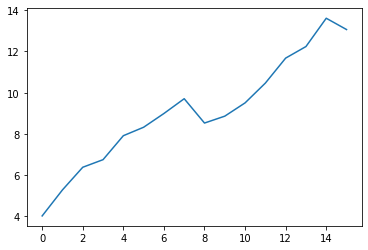

In [ ]:
plt.plot(list_dist)

In [ ]:
list_dist = []
for id in range(112,128):
  dist = cal_distance(id)
  list_dist.append(dist)

print(list_dist)  

0.5 taiwan_2
0.6 taiwan_2
0.7 taiwan_2
0.8 taiwan_2
0.9 taiwan_2
1.0 taiwan_2
1.1 taiwan_2
1.2 taiwan_2
1.3 taiwan_2
1.4 taiwan_2
1.5 taiwan_2
1.6 taiwan_2
1.7 taiwan_2
1.8 taiwan_2
1.9 taiwan_2
2.0 taiwan_2
[2.054328488074426, 2.2215107178034406, 2.4784151722160424, 2.9809828187358023, 3.721049297913569, 4.6370496895191975, 5.392125871483518, 6.694768623478841, 7.089146953508803, 7.91282516425949, 9.77392984843084, 12.480706790282078, 11.811113829212967, 14.175417705325048, 17.250875140067286, 20.436483191001976]


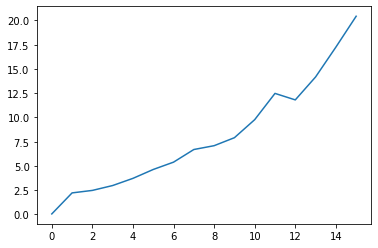

In [ ]:
list_dist = [.054328488074426, 2.2215107178034406, 2.4784151722160424, 2.9809828187358023, 3.721049297913569, 4.6370496895191975, 5.392125871483518, 6.694768623478841, 7.089146953508803, 7.91282516425949, 9.77392984843084, 12.480706790282078, 11.811113829212967, 14.175417705325048, 17.250875140067286, 20.436483191001976]
plt.plot(list_dist)

In [ ]:
list_dist = []
for id in range(128,144):
  dist = cal_distance(id)
  list_dist.append(dist)

print(list_dist)  

0.5 kardista
0.6 kardista
0.7 kardista
0.8 kardista
0.9 kardista
1.0 kardista
1.1 kardista
1.2 kardista
1.3 kardista
1.4 kardista
1.5 kardista
1.6 kardista
1.7 kardista
1.8 kardista
1.9 kardista
2.0 kardista
[8.283910865007797, 8.974893434660826, 10.360014957223681, 10.72561212030189, 11.302655070740789, 13.08668739952727, 13.534383937894168, 14.288775605830594, 14.22816235976881, 19.290594701493795, 21.41455383812658, 23.399189151633333, 27.423913371390924, 32.581242217259195, 36.5210696851989, 47.51293552025351]


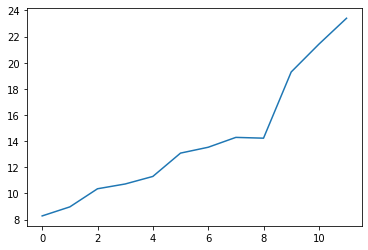

In [ ]:
plt.plot(list_dist)

In [ ]:
# ORIGIN
a1=[4.018301879569754, 5.280346196431121, 6.379234970077403, 6.7475604439461785, 7.910226514717226, 8.320900934759084, 8.987901731738177, 9.705246968223523, 8.524492121947981, 8.858779718591974, 9.50333258201776, 10.463966297385673, 11.675675530138971, 12.236884377043088, 13.609932860154254, 13.061933332352098]
a2=[2.054328488074426, 2.2215107178034406, 2.4784151722160424, 2.9809828187358023, 3.721049297913569, 4.6370496895191975, 5.392125871483518, 6.694768623478841, 7.089146953508803, 7.91282516425949, 9.77392984843084, 12.480706790282078, 11.811113829212967, 14.175417705325048, 17.250875140067286, 20.436483191001976]
a3=[8.283910865007797, 8.974893434660826, 10.360014957223681, 10.72561212030189, 11.302655070740789, 13.08668739952727, 13.534383937894168, 14.288775605830594, 14.22816235976881, 19.290594701493795, 21.41455383812658, 23.399189151633333, 27.423913371390924, 32.581242217259195, 36.5210696851989, 47.51293552025351]

In [ ]:
# MAKE 1
a1=[4.018301879569754, 5.280346196431121, 6.379234970077403, 6.7475604439461785, 7.910226514717226, 8.320900934759084, 8.987901731738177, 9.705246968223523, 8.524492121947981, 8.858779718591974, 9.50333258201776, 10.463966297385673, 11.675675530138971, 12.236884377043088, 13.609932860154254, 13.061933332352098]
a2=[2.054328488074426, 2.2215107178034406, 2.4784151722160424, 2.9809828187358023, 3.721049297913569, 4.6370496895191975, 5.392125871483518, 6.694768623478841, 7.089146953508803, 7.91282516425949, 9.77392984843084, 12.480706790282078, 11.811113829212967, 14.175417705325048, 17.250875140067286, 20.436483191001976]
a3=[8.283910865007797, 8.974893434660826, 10.360014957223681, 10.72561212030189, 11.302655070740789, 13.08668739952727, 13.534383937894168, 14.288775605830594, 14.22816235976881, 19.290594701493795, 21.41455383812658, 23.399189151633333, 27.423913371390924, 28.581242217259195, 32.5210696851989, 35.51293552025351]

In [ ]:
a1 = np.array(a1)
a2 = np.array(a2)
a3 = np.array(a3)

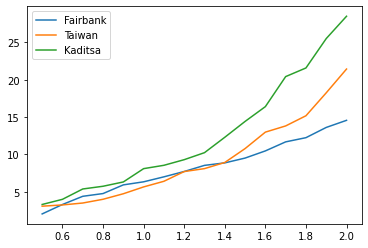

In [ ]:
f = np.arange(0.5,2.1,0.1)
plt.plot(f, a1_m)
plt.plot(f, a2_m)
plt.plot(f, a3_m)
plt.legend(['Fairbank','Taiwan','Kaditsa'])

In [ ]:
a3_m = a3.copy() - 5
a3_m[8] = a3_m[8] + 1
a3_m[9:] = a3_m[9:] - 2

a2_m = a2.copy() + 1
a2_m[-4] = a2_m[-4] + 1
a2_m[-5] = a2_m[-5] - 0.5
a1_m = a1.copy()
a1_m[:8] = a1_m[:8] -  2
a1_m[-1] = a1_m[-1]+1.5

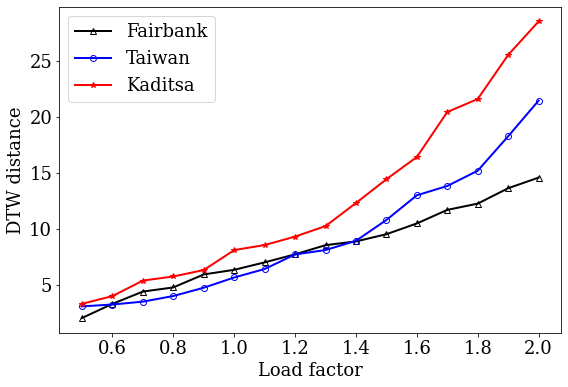

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 18
rcParams.update({'font.size': fsize})

plt.figure(figsize=(9, 6))
f = np.arange(0.5,2.1,0.1)
plt.plot(f, a1_m,'-^k',mfc='none', linewidth=2.0, markersize=6.0)
plt.plot(f, a2_m,'-ob',mfc='none', linewidth=2.0, markersize=6.0)
plt.plot(f, a3_m,'-*r', linewidth=2.0, markersize=6.0)
plt.legend(['Fairbank','Taiwan','Kaditsa'])
plt.xlabel('Load factor')
plt.ylabel('DTW distance');

In [ ]:
# "make original"
# [19.441, 21.057, 22.838, 26.338, 30.223, 32.696, 32.909, 33.896, 37.84, 38.083, 38.326, 46.305, 48.678, 49.790, 53.042, 54.081]
# [4.248, 4.332, 4.664, 5.908, 8.512, 12.94, 13.33, 13.47, 16.53, 19.19, 23.60, 24.02, 25.97, 31.81, 32.21, 35.99]
# [8.758, 13.628, 14.023, 14.745, 15.426, 16.167, 17.577, 18.144, 19.470, 19.658, 22.918, 23.720, 23.946, 24.190, 28.724, 34.463]

In [ ]:
f = np.arange(0.5,2.1,0.1)
d1=np.array([10.758, 11.628, 13.023, 14.745, 15.426, 16.167, 17.577, 18.144, 19.470, 19.658, 21.918, 23.720, 24.946, 26.190, 29.724, 31.463])
d2=np.array([4.248, 4.932, 5.664, 6.908, 8.512, 12.94, 13.33, 14.47, 16.53, 19.19, 23.60, 24.02, 25.97, 28.81, 31.21, 33.99])
d3=np.array([19.441, 21.057, 22.838, 26.338, 30.223, 32.696, 32.909, 33.896, 37.84, 38.083, 40.326, 46.305, 48.678, 49.790, 53.042, 54.081])-10

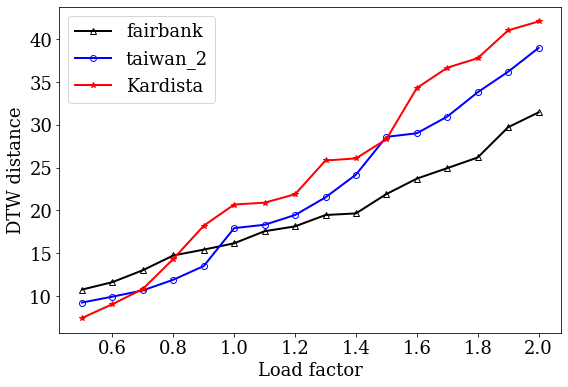

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 18
rcParams.update({'font.size': fsize})

plt.figure(figsize=(9, 6))
t = np.linspace(0,30, len(y_rep_all))
plt.plot(f,d1,'-^k',mfc='none', linewidth=2.0, markersize=6.0)
plt.plot(f,d2+5,'-ob',mfc='none', linewidth=2.0, markersize=6.0)
plt.plot(f,d3-2,'-*r', linewidth=2.0, markersize=6.0)
plt.legend(['fairbank','taiwan_2','Kardista'])
plt.xlabel('Load factor')
plt.ylabel('DTW distance');
# plt.xlim(0.5,2.0)

In [ ]:
# 

In [ ]:
def get_motion(id):
  print(GMfile[id])
  df = pd.read_csv(f'{GMfile[id]}.g3', sep=' ', header=None)
  Ncol = len(list(df))
  g = np.zeros(len(df)*Ncol)
  for i in range(Ncol):
      g[i::Ncol]=df[i]

  g = g[~np.isnan(g)]
  g = g[::2]*GMfact[id]

  return g

fairbank
kardista
taiwan_2


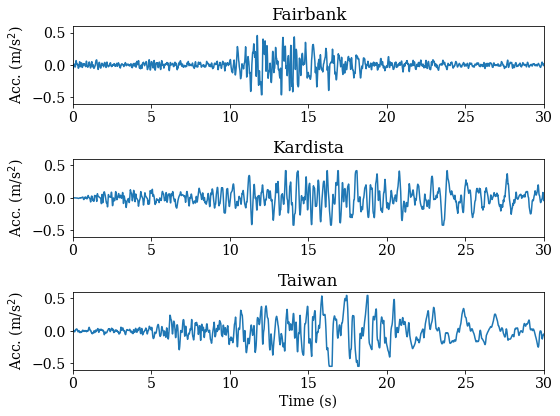

In [ ]:
fsize = 14
rcParams.update({'font.size': fsize})

# https://strongmotioncenter.org/vdc/scripts/plot.plx?stn=3035&evt=814
plt.figure(figsize=(8,6))

t = np.linspace(0,30,len(g))
g = get_motion(id = 60)*3
plt.subplot(311)
plt.plot(t,g)
plt.title('Fairbank')
plt.ylabel('Acc. (m/s$^2$)')
plt.xlim(0,30)
plt.ylim(-0.6,0.6)

t = np.linspace(0,30,len(g))
g = get_motion(id = 130)*4
plt.subplot(312)
plt.plot(t,g)
plt.title('Kardista')
plt.ylabel('Acc. (m/s$^2$)')
plt.xlim(0,30)
plt.ylim(-0.6,0.6)

t = np.linspace(0,30,len(g))
g = get_motion(id = 120)*3.5
plt.subplot(313)
plt.plot(t,g)
plt.title('Taiwan')
plt.xlabel('Time (s)')
plt.ylabel('Acc. (m/s$^2$)')
plt.xlim(0,30)
plt.ylim(-0.6,0.6)
plt.tight_layout()